# LMS Video Engagement Analysis

In [1]:
# Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble        import RandomForestClassifier
from sklearn.compose         import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

# Apply Seaborn’s white‐grid theme globally
sns.set(style='whitegrid')

# Set the default plot figure size
plt.rcParams['figure.figsize'] = (8, 5)

## 1. Exploratory Data Analysis (EDA)

#### 1.1  Load & Inspect Data

In [2]:
# Load data
df = pd.read_csv('LMS Video Engagement Data.csv')

In [3]:
# Inspect data

# Shape
print(f"Shape: {df.shape}\n")

# Info
print("Info:")
df.info()
print("\n") 

# Describe
print("Statistical Summary:")
display(df.describe())
print("\n")

# Head
print("First 5 rows:")
display(df.head())

Shape: (668471, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668471 entries, 0 to 668470
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   student_id               668471 non-null  object 
 1   course_id                668471 non-null  int64  
 2   course_code              668471 non-null  object 
 3   video_title              668471 non-null  object 
 4   role                     668471 non-null  object 
 5   completion_rate_percent  668471 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 30.6+ MB


Statistical Summary:


,course_id,completion_rate_percent
count,668471.000000,668471.000000
mean,232.351996,78.802923
std,127.627026,36.088697
min,142.000000,0.800000
25%,160.000000,69.700000
50%,165.000000,100.000000
75%,249.000000,100.000000
max,1548.000000,100.000000




First 5 rows:


,student_id,course_id,course_code,video_title,role,completion_rate_percent
0,1fed547bb417,144,ACC101,ACC101LL_Y1_01_02,Student,100.0
1,add68f45e669,144,ACC101,ACC101LL_Y1_01_02,Student,100.0
2,b4b56e4d11b5,144,ACC101,ACC101LL_Y1_01_02,Student,95.2
3,c5fb34ebdb38,144,ACC101,ACC101LL_Y1_01_02,Student,100.0
4,0d78a078190e,144,ACC101,ACC101LL_Y1_01_02,Student,3.2


In [4]:
# Check unique-value counts for each column
unique_counts = pd.DataFrame({
    'Column': df.columns,
    'Unique Count': [df[col].nunique() for col in df.columns]
})
display(unique_counts)

,Column,Unique Count
0,student_id,4979
1,course_id,174
2,course_code,180
3,video_title,4273
4,role,16
5,completion_rate_percent,956


**Insight:**

- From the unique count output above, there are 174 unique `course_id` values and 180 unique `course_code` values. Ideally, the mapping should be one-to-one, but the unique counts suggest there may be mismatches.

- To get a clearer picture of how these two columns relate to each other. We will first evaluate the frequency of each code-id pair to see if any `course_code` maps to multiple `course_ids` or if the reverse happens by analyzing the relationship between `course_id` and `course_code` and checking the frequency distribution of both columns and then look for any one-to-many or many-to-one mappings, then compute any course_id values mapping to multiple course_code values and vice versa.

Course IDs with multiple codes:


course_id,unique_course_codes
163,3
187,2
247,2
249,2
269,2


Affected course_id values: [163, 187, 247, 249, 269]
ID 163 → Codes: 'INTRODUCTION TO COMPUTING'(43917), 'Introduction to Computing'(42757), 'COS101'(23027)
ID 187 → Codes: 'COS102'(19943), 'Introduction to Problem Solving'(6281)
ID 247 → Codes: 'MTH102'(7997), 'Elementary Mathematics (Calculus)II'(1887)
ID 249 → Codes: 'ACC102'(2332), 'Introduction to Financial Accounting II'(292)
ID 269 → Codes: 'INTRODUCTION TO WEB TECHNOLOGIES'(9822), 'Introduction to Web Technologies'(1848)


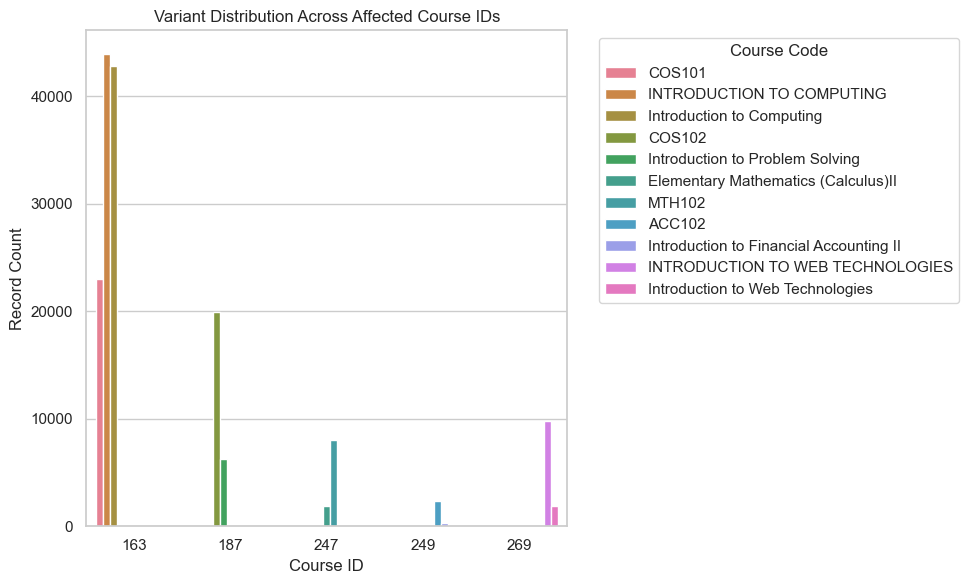



Course Codes with multiple IDs:


course_code,unique_course_ids


Affected course_code values: []


In [5]:
# Count distinct course_code values per course_id
id_code_map = (
    df.groupby('course_id')['course_code']
      .nunique()
      .reset_index(name='unique_course_codes')
)

# Count distinct course_id values per course_code
code_id_map = (
    df.groupby('course_code')['course_id']
      .nunique()
      .reset_index(name='unique_course_ids')
)

# Show Course IDs that map to >1 Course Codes
multi_codes = (
    id_code_map[id_code_map['unique_course_codes'] > 1]
    .reset_index(drop=True)               
)
print("Course IDs with multiple codes:")
display(multi_codes.style.hide(axis="index"))
aff_ids = multi_codes['course_id'].tolist()
print("Affected course_id values:",aff_ids)
for cid in aff_ids:
    # codes = df.loc[df['course_id']==cid, 'course_code'].unique()
    # print(f"ID {cid} → Codes: {codes}")
    codes = df[df['course_id'] == cid]['course_code']
    code_vc = codes.value_counts()
    # Format as: 'CODE' (count)
    formatted_codes = ", ".join([f"'{code}'({code_cnt})" for code, code_cnt in code_vc.items()])
    print(f"ID {cid} → Codes: {formatted_codes}")

# Plot data of Course IDs with multiple codes
mismatch_id = (
    df[df['course_id'].isin(aff_ids)]
      .groupby(['course_id','course_code'])
      .size()
      .reset_index(name='count')
)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=mismatch_id,
    x='course_id',
    y='count',
    hue='course_code'
)
plt.xlabel('Course ID')
plt.ylabel('Record Count')
plt.title('Variant Distribution Across Affected Course IDs')
plt.legend(title='Course Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
    
# Show Course Codes that map to >1 Course IDs
multi_ids = (
    code_id_map[code_id_map['unique_course_ids'] > 1]
    .reset_index(drop=True)
)
print("\n\nCourse Codes with multiple IDs:")
display(multi_ids.style.hide(axis="index"))
aff_codes = multi_ids['course_code'].tolist()
print("Affected course_code values:",aff_codes)
for ccd in aff_codes:
    # id = df.loc[df['course_code']==ccd, 'course_id'].unique()
    # print(f"Code {ccd} → IDs: {id}")
    id_s = df[df['course_id'] == ccd]['course_code']
    id_vc = id_s.value_counts()
    # Format as: 'CODE' (count)
    formatted_ids = ", ".join([f"'{ids}'({id_cnt})" for ids, id_cnt in id_vc.items()])
    print(f"Code {ccd} → IDs: {formatted_ids}")

**Insight:**

- From the output above, we can see that there are no bidirectional conflicts, that is; we only see mismatches in the ID → code direction  but no `course_code` maps to more than one `course_id`. That means the numeric IDs are reliably unique, and it’s only the human-readable labels that have drifted.
  
- This can be resolved by building a dominant‐code mapping for all IDs and pick the most frequent `course_code` for each  `course_id`

In [6]:
# Compute the dominant‐code mapping for all IDs
dominant_map = (
    df
      .groupby(['course_id','course_code'])
      .size()
      .reset_index(name='count')
      .sort_values(['course_id','count'], ascending=[True,False])
      .drop_duplicates('course_id')
      .set_index('course_id')['course_code']
      .to_dict()
)

df['dominant_course_code'] = df['course_id'].map(dominant_map)


# # CHECKS
# # Check a few rows to verify
# display(df.loc[df['course_id'].isin(aff_ids), 
#                ['course_id','course_code','dominant_course_code']].drop_duplicates())

# Check unique-value counts for each column
unique_counts = pd.DataFrame({
    'Column': df.columns,
    'Unique Count': [df[col].nunique() for col in df.columns]
})
display(unique_counts)

,Column,Unique Count
0,student_id,4979
1,course_id,174
2,course_code,180
3,video_title,4273
4,role,16
5,completion_rate_percent,956
6,dominant_course_code,174


In [7]:
# Check distinct roles
print(df["role"].unique())

['Student' 'Teacher Admin' 'Admin Student' 'Observer Teacher' 'Admin'
 'Admin Teacher' 'Admin Teacher Student' 'Teacher'
 'Admin Observer Student' 'Student Admin' 'Student Teacher Admin'
 'Teacher Admin Student' 'Admin Observer Teacher Student'
 'Student Teacher' 'Teacher Student' 'Observer Admin']


,Role,Count,Percentage %
0,Student,663257,99.2200
1,Admin,1986,0.2971
2,Admin Student,925,0.1384
3,Teacher,792,0.1185
4,Admin Teacher,754,0.1128
5,Admin Teacher Student,365,0.0546
6,Teacher Admin,157,0.0235
7,Student Admin,129,0.0193
8,Teacher Admin Student,46,0.0069
9,Teacher Student,29,0.0043


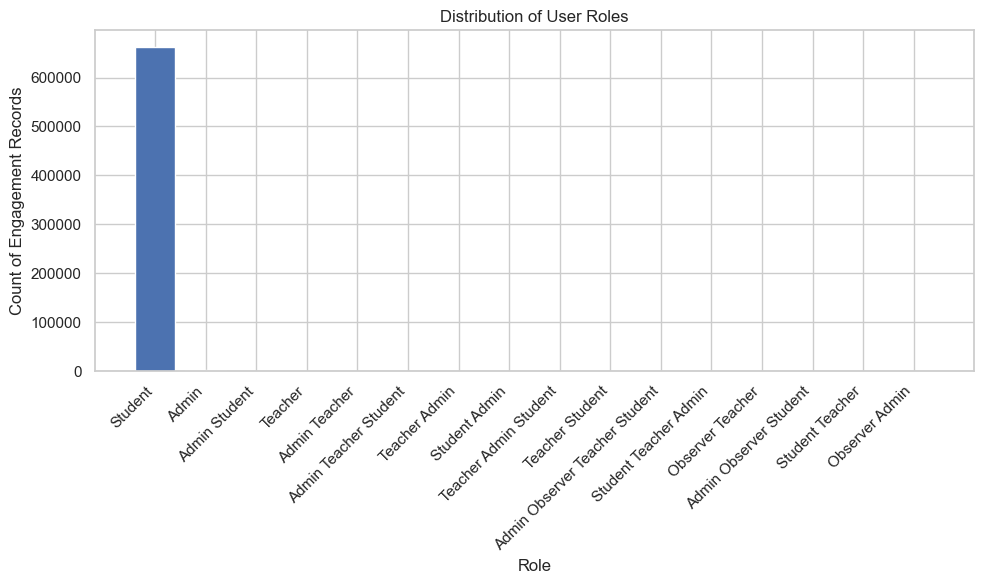

In [8]:
# Create a DataFrame of role counts
role_counts = (
    df['role']
    .value_counts()
    .reset_index()
)
role_counts.columns = ['Role', 'Count']

# Compute percentage
total = role_counts['Count'].sum()
role_counts['Percentage %'] = (role_counts['Count'] / total * 100).round(4)

display(role_counts)

# Plot a bar chart of the distribution
plt.figure(figsize=(10, 6))
plt.bar(role_counts['Role'], role_counts['Count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Role')
plt.ylabel('Count of Engagement Records')
plt.title('Distribution of User Roles')
plt.tight_layout()
plt.show()

**Insight:**

- Based off the distribution of the roles and ambiguity of some of the role headers like: `Admin Student`, `Student Teacher Admin`, etc., we will be using only the `Student` column to classify the learners. so therefore any analysis that appplies to "learner" for this work will be assumed to imply "students".

- Also, it's quite safe to use the `Student` as generalized role for learners because it consists of a very large percentage (99.22%) of the data so it should be good enough to genralize on the data.

- So now, we will now create a new dataframe to do learner related analysis

In [9]:
# Create learner dataframe for “Student” roles

# df['is_student'] = df['role'].str.contains('Student')
# learner_df = df[df['is_student']].copy()

df['is_student'] = df['role'] == 'Student'
learner_df = df[df['is_student']].copy()

print(f"Unique number of roles in learners table is: {learner_df["role"].nunique()} ----->>> {learner_df["role"].unique()}")

Unique number of roles in learners table is: 1 ----->>> ['Student']


In [10]:
# Check unique-value counts for each column
unique_counts = pd.DataFrame({
    'Column': learner_df.columns,
    'Unique Count': [learner_df[col].nunique() for col in learner_df.columns]
})
display(unique_counts)

,Column,Unique Count
0,student_id,4793
1,course_id,174
2,course_code,180
3,video_title,4247
4,role,1
5,completion_rate_percent,956
6,dominant_course_code,174
7,is_student,1


In [11]:
# Drop redundant columns 

learner_df = learner_df.drop(columns=[
    'course_code', # redundant due to it's high correlation to course_id
    'dominant_course_code', # also redundant due to it's high correlation to course_id
    'role', # every row has constant role == 'Student' so zero variance and contributes nothing to the model 
    'is_student' # is_student is always True (1). it’s another constant that neither explains nor predicts anything
])


In [13]:
# Verify
# Shape
print(f"Shape: {learner_df.shape}\n")

# Info
print("Info:")
learner_df.info()
print("\n") 

display(learner_df.head())

Shape: (663257, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 663257 entries, 0 to 668470
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   student_id               663257 non-null  object 
 1   course_id                663257 non-null  int64  
 2   video_title              663257 non-null  object 
 3   completion_rate_percent  663257 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 25.3+ MB




,student_id,course_id,video_title,completion_rate_percent
0,1fed547bb417,144,ACC101LL_Y1_01_02,100.0
1,add68f45e669,144,ACC101LL_Y1_01_02,100.0
2,b4b56e4d11b5,144,ACC101LL_Y1_01_02,95.2
3,c5fb34ebdb38,144,ACC101LL_Y1_01_02,100.0
4,0d78a078190e,144,ACC101LL_Y1_01_02,3.2


#### 1.2 Average & Median Watch Duration per Video

In [14]:
video_stats = (
    df
      .groupby('video_title')['completion_rate_percent']  # group data by video title
      .agg([
          'mean',    # compute the average completion rate
          'median',  # compute the median completion rate
          'count'    # count how many times each video was viewed
      ])
      .rename(columns={
          'mean': 'average_completion_percent',    # rename for clarity
          'median': 'median_completion_percent',  # rename for clarity
          'count': 'views'             # rename to indicate number of view events
      })
)

# Sort videos by highest average completion rate and display the top 10
video_stats.sort_values('average_completion_percent', ascending=False).head(10)

,average_completion_percent,median_completion_percent,views
video_title,,,
ECO208LL_Y2_02_12,100.0,100.0,1
ACC212_Y2_02_01_B,100.0,100.0,6
ACC217_Y2_01_11_A,100.0,100.0,15
ECO206_Y2_02_05_A,100.0,100.0,9
GST222_Y2_01_01,100.0,100.0,1
ECO104_Y1_02_10a,100.0,100.0,18
Live Lesson With Google Meet (ENT 124) – 2024_10_30 15_39 WAT – Recording,100.0,100.0,1
ACC216_Y2_02_08_B,100.0,100.0,4
PIO212_Y2_02_09_A,100.0,100.0,37


In [15]:
# Export the average and median views duration table to a CSV file
video_stats.to_csv('video_stats.csv', index=True)

#### 1.2 Top 10 most-watched videos by total duration by the learners.
To calculate the most watched videos by aggregate engagement (by learners), we will have to use the `learner_df` data we created

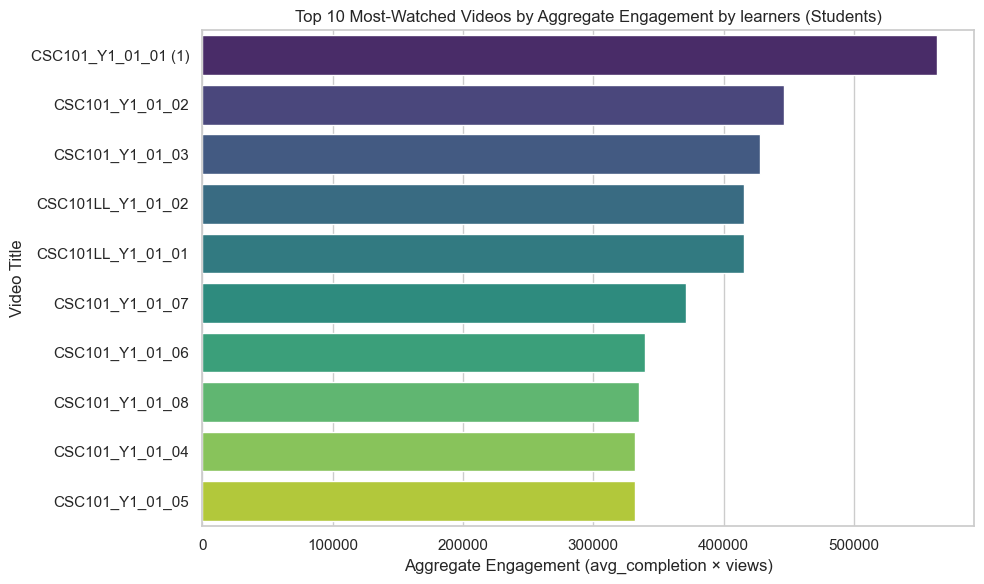

In [70]:
# Compute per-video stats on learner-only data
video_stats_learner = (
    learner_df
      .groupby('video_title')['completion_rate_percent']
      .agg(
          avg_completion = 'mean',   # average % watched
          views          = 'count'   # total number of learner views
      )
)

# Approximate total engagement as avg_completion * views
video_stats_learner['total_engagement'] = (
    video_stats_learner['avg_completion'] * video_stats_learner['views']
)

# Top 10 videos
top10 = video_stats_learner \
         .sort_values('total_engagement', ascending=False) \
         .head(10) \
         .reset_index()

# Plot top 10 most engaged video
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10,
    x='total_engagement',
    y='video_title',
    hue='video_title', 
    palette='viridis',
    dodge=False 
)
plt.xlabel('Aggregate Engagement (avg_completion × views)')
plt.ylabel('Video Title')
plt.title('Top 10 Most-Watched Videos by Aggregate Engagement by learners (Students)')
plt.tight_layout()
plt.show()

## 2. Learner Engagement Metric

In [72]:
def compute_engagement_score(df: pd.DataFrame) -> pd.Series:
    """
    Compute an engagement score per learner.
    
    Score = (average completion rate as a fraction) × log1p(number of unique videos watched)
    
    Parameters
    ----------
    df : pd.DataFrame
        The engagement log, with columns 'student_id', 'completion_rate_percent', and 'video_title'.
    
    Returns
    -------
    pd.Series
        engagement_score indexed by student_id.
    """
    # Aggregate per learner
    stats = df.groupby('student_id').agg(
        avg_completion   = ('completion_rate_percent', 'mean'),
        unique_videos    = ('video_title',           'nunique')
    )
    
    # Compute the score
    stats['engagement_score'] = (stats['avg_completion'] / 100) * np.log1p(stats['unique_videos'])
    
    return stats['engagement_score']

In [74]:
# --- Engagement score per learner ---
eng_scores = compute_engagement_score(learner_df)

# Sort by descending and pull the top 5
top5_learners = eng_scores.sort_values(ascending=False).head(5)

display(top5_learners)

student_id
e4eb1c33f5d9    6.634052
363a743d7b2d    6.622031
50a41c38d354    6.615120
8612bd97bd7b    6.606974
d4a80649d84f    6.590908
Name: engagement_score, dtype: float64

## 3. Churn Prediction (Learner’s Completion Threshold)

#### 3.1 Generate Churn Label

In [81]:
# 1 for → churn (completion < 49%),  0 for → non-churn
learner_df['churn'] = (learner_df['completion_rate_percent'] < 49).astype(int)
learner_df['churn'].value_counts()

churn
0    520733
1    142524
Name: count, dtype: int64

In [85]:
learner_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 663257 entries, 0 to 668470
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   student_id               663257 non-null  object 
 1   course_id                663257 non-null  int64  
 2   video_title              663257 non-null  object 
 3   completion_rate_percent  663257 non-null  float64
 4   churn                    663257 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 30.4+ MB


#### 3.2 Model Training & Evaluation

Model approach:

a. LogisticRegression  on completion_rate_percent to verify  an upper‐bound on “easy” performance on predicting `churn` directly from the `completion_rate_percen`

b. Random Forest on categorical `course_id` & `video_title` tests whether certain courses or videos are especially risky for churn—potentially surfacing low‐engagement content that needs rework.

##### a. Single-feature logistic regression

In [90]:
# Prepare feature and target
X_base = learner_df[['completion_rate_percent']]
y_base = learner_df['churn']

In [92]:
#  Split data into training and test sets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base,
    test_size=0.2,
    stratify=y_base, 
    random_state=42 
)

In [104]:
# Initialize the logistic regression model
clf_base = LogisticRegression(max_iter=500)

# Evaluate baseline performance via 5-fold cross-validation on the training set
cv_scores = cross_val_score(
    clf_base,
    Xb_train,
    yb_train,
    cv=5,
    scoring='roc_auc' #ROC-AUC to account for class imbalance
)
print("Baseline CV ROC-AUC:", cv_scores.mean().round(3))

Baseline CV ROC-AUC: 1.0


In [106]:
# Fit the model training data
clf_base.fit(Xb_train, yb_train)

LogisticRegression(max_iter=500)

In [108]:
# Generate predictions on the test set
y_pred = clf_base.predict(Xb_test)
y_proba = clf_base.predict_proba(Xb_test)[:, 1]

In [110]:
# Classification report (precision, recall, f1-score) on test set
print("Baseline Test Report:")
print(classification_report(yb_test, y_pred))

Baseline Test Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104147
           1       1.00      1.00      1.00     28505

    accuracy                           1.00    132652
   macro avg       1.00      1.00      1.00    132652
weighted avg       1.00      1.00      1.00    132652



In [112]:
# Compute test ROC-AUC for a probability-based performance metric
print("Baseline Test ROC-AUC:", roc_auc_score(yb_test, y_proba).round(3))

Baseline Test ROC-AUC: 1.0


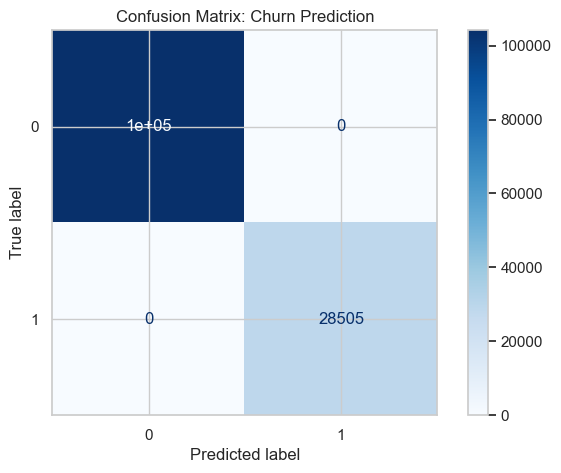

In [114]:
# Plot confusion matrix
cm = confusion_matrix(yb_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_base.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Churn Prediction")
plt.show()

In [116]:
# Save the Linear Regression model 
model_path = "baselineLR_churn_model.joblib"
joblib.dump(clf_base, model_path)
print(f"Saved baseline model to: {model_path}")

Saved baseline model to: baselineLR_churn_model.joblib


**Insight:**

- it is not a surprise that the accuracy is 100% because since churn is literally a threshold on `completion_rate_percent`, any model that “learns” that threshold (or approximates it) will score near 100% on both training and test. That’s why we saw a CV ROC-AUC around 1.0

- This single-feature logistic regression is useful as a baseline sanity check. It lets us verify our end-to-end data pipeline and modeling of interpreting `churn` from `completion_rate_percent` also is efficient for quick deployment setup.

##### b. Multi-feature Random Forest Model

In [127]:
# Copy learner_df to avoid modifying the original
df_model = learner_df.copy() 

In [177]:
# Convert categorical fields to string dtype for encoding
df_model['course_id_cat']   = df_model['course_id'].astype(str)
df_model['video_title_cat'] = df_model['video_title'].astype(str)

In [179]:
# Define feature matrix and target vector
X = df_model[['course_id_cat', 'video_title_cat']]
y = df_model['churn']

In [181]:
# Build preprocessing and modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_enc", OrdinalEncoder(
            handle_unknown='use_encoded_value', unknown_value=-1
        ), ['course_id_cat', 'video_title_cat'])
    ], # using OrdinalEncoder because RandomForest handles integer codes without assuming order
    remainder='drop'
)

rf_pipeline = Pipeline(steps=[
    ("encode", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1    # parallelize across cores
    ))
])

In [183]:
# Split data into train/test sets
Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X, y,
    test_size=0.2,       
    stratify=y, 
    random_state=42
)

In [185]:
# Cross-validate pipeline on training data
cv_scores = cross_val_score(
    rf_pipeline,
    Xt_train, yt_train,
    cv=3,               
    scoring='roc_auc' 
)
print(f"Random Forest CV ROC-AUC: {cv_scores.mean():.3f}")

Random Forest CV ROC-AUC: 0.695


In [186]:
# Define the gridcv to search for best model parameters
param_grid = {
    "rf__n_estimators":   list(range(500, 701, 50)),
    "rf__max_depth":      [None] + list(range(20, 31, 5)),
    "rf__max_features":   ["sqrt", "log2"],
    "rf__min_samples_split":  list(range(5, 7)),
}

In [187]:
# Build the GridSearchCV over existing pipeline
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",    # optimize for ROC-AUC
    cv=3,                 # 3-fold CV
    n_jobs=-1,            # parallelize across cores
    verbose=2
)

In [188]:
# Run the grid search on the training data
grid_search.fit(Xt_train, yt_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('encode',
                                        ColumnTransformer(transformers=[('cat_enc',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['course_id_cat',
                                                                          'video_title_cat'])])),
                                       ('rf',
                                        RandomForestClassifier(max_depth=10,
                                                               n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 20, 25, 30],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_split': [5, 6],
                         'rf__n_estimators': [500, 550, 600, 650, 700]},
             scoring='roc_auc', verbose=2)

In [193]:
# Inspect the best parameters & CV score
print("Best hyperparameters:", grid_search.best_params_)
print(f"Best CV ROC-AUC: {grid_search.best_score_:.3f}")

Best hyperparameters: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 6, 'rf__n_estimators': 700}
Best CV ROC-AUC: 0.700


In [195]:
# Evaluate the tuned model on the test set
best_model = grid_search.best_estimator_
y_pred  = best_model.predict(Xt_test)
y_proba = best_model.predict_proba(Xt_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(yt_test, y_pred))
print(f"Test ROC-AUC: {roc_auc_score(yt_test, y_proba):.3f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.97      0.88    104147
           1       0.60      0.14      0.23     28505

    accuracy                           0.80    132652
   macro avg       0.70      0.56      0.56    132652
weighted avg       0.76      0.80      0.74    132652

Test ROC-AUC: 0.704


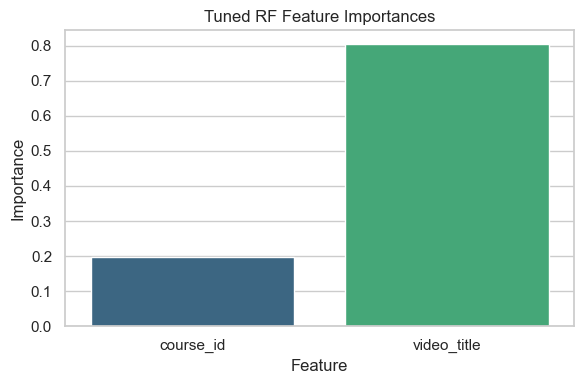

In [197]:
# Feature importances for the tuned Random Forest
importances = best_model.named_steps['rf'].feature_importances_
feature_names = ['course_id', 'video_title']

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# # Plot feature importances
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=fi_df,
    x='feature',
    y='importance',
    hue='feature',      # assign the categorical axis as hue
    palette='viridis',
    dodge=False         # keep one bar per feature
)

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Tuned RF Feature Importances')
plt.tight_layout()
plt.show()

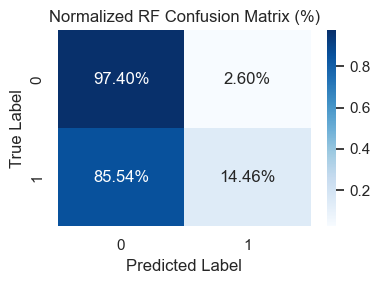

In [199]:
# Confusion matrix on RF tuned model
y_pred_tuned = best_model.predict(Xt_test)
cm = confusion_matrix(yt_test, y_pred_tuned, normalize='true')

plt.figure(figsize=(4, 3))
sns.heatmap(
    cm, annot=True, fmt='.2%', cmap='Blues',
    xticklabels=best_model.named_steps['rf'].classes_,
    yticklabels=best_model.named_steps['rf'].classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized RF Confusion Matrix (%)')
plt.tight_layout()
plt.show()

In [201]:
# 6) Persist the best pipeline
model_file = "rf_churn_model.joblib"
joblib.dump(best_model, model_file)
print(f"\nSaved tuned Random Forest pipeline to: {model_file}")


Saved tuned RF pipeline to: rf_churn_model.joblib


**Insight:**

- The model is bias towards the majority class `0`. The model sees fewer churn samples and may have misclassified them as “less costly” during split‐criterion optimization. And the ROC-AUC of 0.70 indicates the model is better than random but far from “production-grade as it can still be improved by oversampling the churners (via SMOTE).

- I didn't explore using SMOTE oversampling int his notebook because of the time constraint of submission deadline and having to re-run the gridcv search for optimal paramters, the previous ones i ran in this notebopok took a very long time to run on my machine.

## 4. Clustering Learners

In [209]:
# Create per‐learner feature matrix
learner_feats = (
    learner_df
      .groupby('student_id')
      .agg(
          avg_completion=('completion_rate_percent', 'mean'),
          videos_watched=('video_title', 'nunique')
      )
)

In [215]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(learner_feats)

# Fit K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
learner_feats['cluster'] = kmeans.fit_predict(X_scaled)

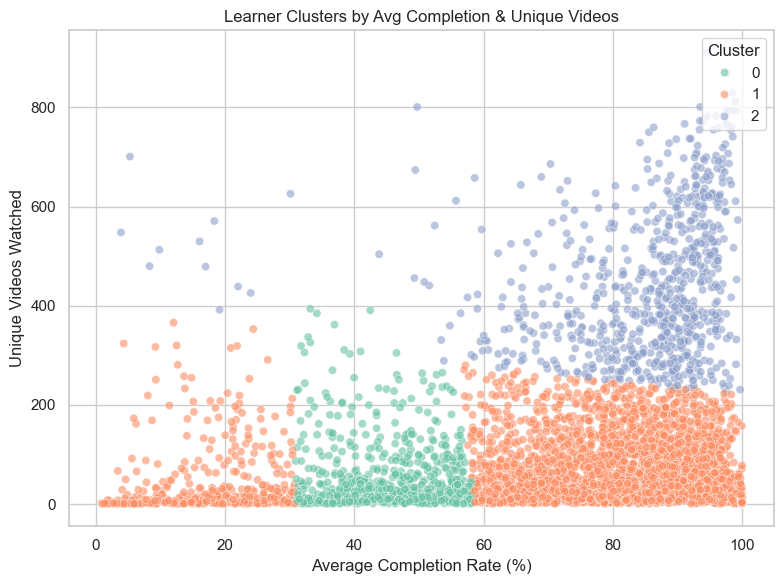

In [221]:
# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=learner_feats.reset_index(),
    x='avg_completion',
    y='videos_watched',
    hue='cluster',
    palette='Set2',
    alpha=0.6
)
plt.title('Learner Clusters by Avg Completion & Unique Videos')
plt.xlabel('Average Completion Rate (%)')
plt.ylabel('Unique Videos Watched')
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()

In [225]:
# 5) Profile each cluster
cluster_summary = (
    learner_feats
      .groupby('cluster')
      .agg(
          count_learners=('cluster','size'),
          mean_completion=('avg_completion','mean'),
          mean_videos=('videos_watched','mean')
      )
      .sort_values('mean_completion', ascending=True)
)
display(cluster_summary.style.format({
    'mean_completion': '{:.1f}%',
    'mean_videos': '{:.1f}'
}))

,count_learners,mean_completion,mean_videos
cluster,,,
0,708,46.1%,53.3
1,3321,72.8%,65.4
2,764,84.7%,441.6


**Insight:** Clusters separate casual viewers, regular learners, and power users.

Three distinct learner segments emerged from clustering on average completion and unique videos watched:

- Casual Viewers (708 learners): they complete only 46% despite viewing approzimately 53 videos.

- Regular Learners (3321 learners): they complete 73% and watch about 65 videos.

- Power Users (764 learners): they finish 85% of video content and watch approximately 442 unique videos.

## 5. Anomaly Detection

In [241]:
# Group learners whose every video view falls between 40–50% completion
anomalous_learners = learner_df \
    .groupby('student_id')['completion_rate_percent'] \
    .filter(lambda rates: rates.between(40, 50).all()) \
    .index \
    .to_series() \
    .map(lambda idx: learner_df.loc[idx, 'student_id']) \
    .unique().tolist()

print(f"Number of anomalous learners: {len(anomalous_learners)}")

Number of anomalous learners: 6


In [243]:
# Learners with all views between 40-50%
anomaly_df = (
    learner_df[learner_df['student_id'].isin(anomalous_learners)]
      [['student_id','completion_rate_percent']]
      .sort_values(['student_id','completion_rate_percent'])
      .reset_index(drop=True)
)

# 3) Display it
display(anomaly_df)

,student_id,completion_rate_percent
0,080fdbe8ba99,46.4
1,127666ab5a55,42.9
2,648ce9db6c1e,45.3
3,830984f1c0b9,50.0
4,9b91182da362,40.5
5,fa276bca94a8,47.8


## 6. Learning Path Optimization

In [306]:
# Compute per-video halfway‐abandonment rate
drop_halfway = (
    learner_df
      .assign(abandoned=lambda d: d['completion_rate_percent'].between(40, 60))
      .groupby('video_title')['abandoned']
      .mean()                      # fraction of views abandoned halfway
      .reset_index(name='abandon_rate')
      .sort_values('abandon_rate', ascending=False)
)

# Top 5 most‐abandoned‐halfway videos
top5 = drop_halfway.head()
print(f"The top 5 most abandoned halfway videos are:")
display(top5.style.hide(axis="index").format({'abandon_rate':'{:.1%}'}))

The top 5 most abandoned halfway videos are:


video_title,abandon_rate
eng2,100.0%
Eng 4,100.0%
ECO209_Y2_01_11A,73.7%
ACC212LL_Y2_02_11,50.0%
ACC204LL_Y2_02_05,50.0%


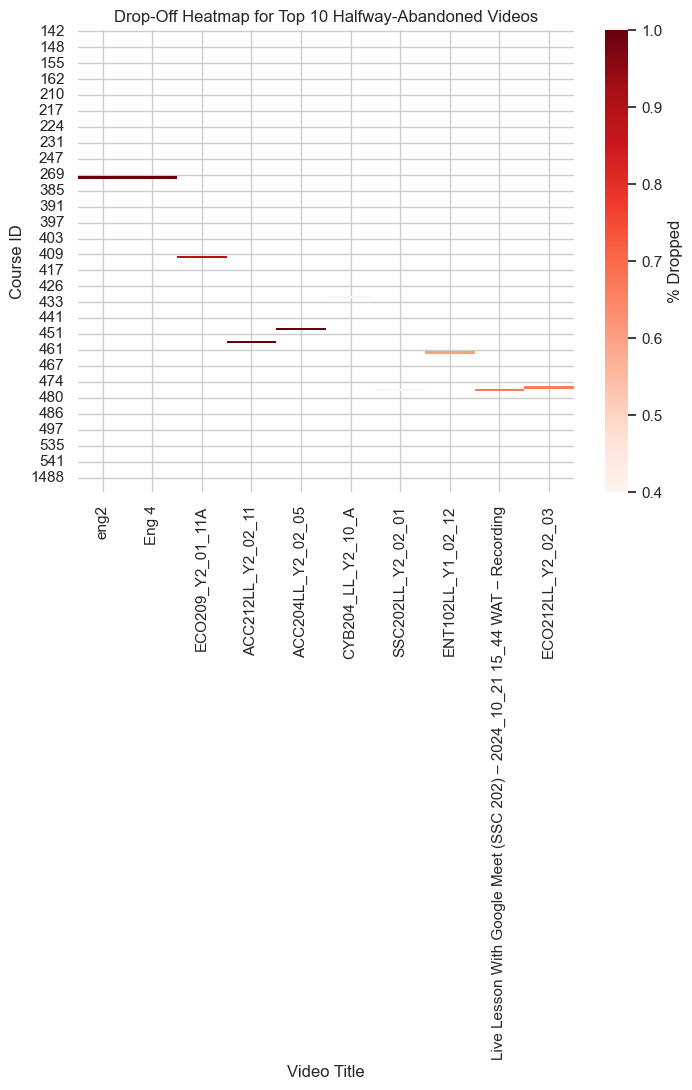

In [304]:
# Drop-Off Pattern by Course & Video

top10_dropped_videos = drop_halfway.head(10)['video_title'].tolist()

drop_pattern_top10 = (
    learner_df
      .assign(dropped=lambda d: d['completion_rate_percent'] < 50)
      .groupby(['course_id','video_title'])['dropped']
      .mean()
      .unstack('video_title')
      [top10_dropped_videos] 
)
plt.figure(figsize=(8,6))
sns.heatmap(
    drop_pattern_top10,
    cmap='Reds',
    cbar_kws={'label':'% Dropped'},
    fmt='.0%'
)
plt.title('Drop-Off Heatmap for Top 10 Halfway-Abandoned Videos')
plt.xlabel('Video Title')
plt.ylabel('Course ID')
# plt.tight_layout()
plt.show()


**Insight:**

- Courses 269 and 417 show almost 100% drop-off rate on videos `eng2` and `Eng 4` meaning virtually no learner makes it past halfway. Courses 451 & 461 also have high drop off rate on video `ACC204LL_Y2_02_11` including course 441 with  >80% abandonment on video `CYB204LL_Y2_02_05`.  Maybe investigating into the context of the videos as it applies to this courses may give direction into where the issue may be OR also checking for other issues like pacing issues, confusing transitions around the midpoint, or technical glitches.

- No single course is uniformly red across all ten videos so it's safe to say that each problematic cell is a course-video pairing so therefore the issue lies with individual video content or structure, not with an entire course’s design.

## 7. Predictive Modeling

In [313]:
# Define the target: completed (100%) vs not
learner_df['completed'] = (learner_df['completion_rate_percent'] == 100).astype(int)

In [315]:
# Compute each learner’s average past completion
student_avg = (
    learner_df
      .groupby('student_id')['completion_rate_percent']
      .mean()
      .rename('student_avg_completion')
)
model_df = learner_df.join(student_avg, on='student_id')

In [323]:
# Encode the course as categorical features
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
course_ohe = pd.DataFrame(
    enc.fit_transform(model_df[['course_id']]),
    columns=enc.get_feature_names_out(['course_id']),
    index=model_df.index
)

In [325]:
# Assemble feature matrix X and label y
X = pd.concat([model_df[['student_avg_completion']], course_ohe], axis=1)
y = model_df['completed']

In [327]:
# Split into train and test sets, stratifying to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [329]:
# Train the logistic regression baseline
clf = LogisticRegression(max_iter=500)

# 5-fold CV ROC-AUC on training data
cv_auc = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"CV ROC-AUC: {cv_auc:.3f}")

CV ROC-AUC: 0.758


In [331]:
# Fit on training set 
clf.fit(X_train, y_train)

# Evaluate on test set
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.39      0.50     45972
           1       0.74      0.91      0.82     86680

    accuracy                           0.73    132652
   macro avg       0.72      0.65      0.66    132652
weighted avg       0.73      0.73      0.71    132652

Test ROC-AUC: 0.758


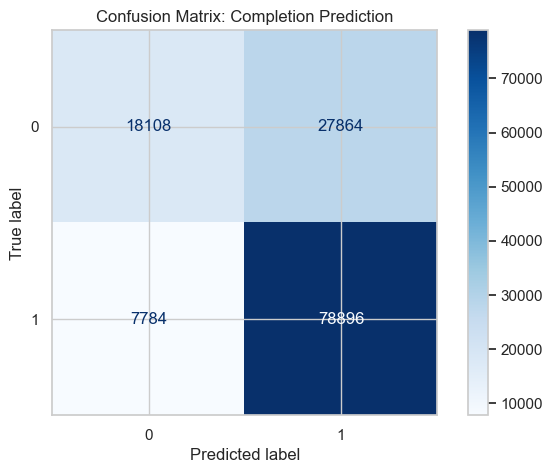

In [333]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Completion Prediction")
plt.show()

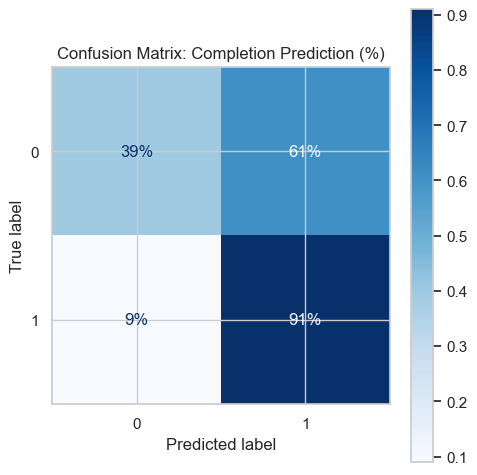

In [345]:
cm_pct = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_pct,
    display_labels=clf.classes_
)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    ax=ax,
    cmap='Blues',
    values_format='.0%'
)
plt.title("Confusion Matrix: Completion Prediction (%)")
plt.tight_layout()
plt.show()

In [337]:
# Save the encoder and model for deployment
joblib.dump({'encoder': enc, 'model': clf}, 'learner_completion_model.joblib')
print("Saved model and encoder to 'learner_completion_model.joblib'")

Saved model and encoder to 'learner_completion_model.joblib'


**Insight:**

- The model is very good at predicting who will finish a video but struggles a little in flagging those who won’t.

## 8. Cluster-Aware Video Recommendation

Each learner cluster favors different contents so recommending each cluster’s top‐completion videos could personalize learning paths, boost engagement, and reduce drop-off. The following code produces the **top 5 video recommendations** for each learner segment (cluster) based on how consistently learners in that cluster finish a given video.  

1. **Merge cluster labels**  
   Each student’s cluster assignment (`learner_feats.cluster`) is taken and joined back onto the raw view records in `learner_df`. This gives us a DataFrame where every view event knows which cluster that learner belongs to.

2. **Aggregate cluster-video statistics**  
   For each `(cluster, video_title)` pair, then computing:  
   - `avg_completion`: the mean completion percentage among that cluster’s views of the video  
   - `views`: how many times the video was watched by learners in that cluster

3. **Filter and rank**  
   Then any video with fewer than **50 views** is disregarded (to ensure statistical reliability), then sort each cluster’s videos by `avg_completion` in descending order and take the **top 5**. These are the videos that cluster is most likely to finish.

4. **Display recommendations**  
   Finally, a neat table showing is rendered, for each cluster, the five videos with the highest completion rates along with their view


In [351]:
# Joining learner cluster features cluster labels back to each view
stu_clustered = (
    learner_df
      .merge(
          learner_feats[['cluster']],
          left_on='student_id',
          right_index=True
      )
)

In [354]:
# Computing cluster-level video stats
cluster_video_stats = (
    stu_clustered
      .groupby(['cluster','video_title'])
      .agg(
          avg_completion=('completion_rate_percent','mean'),
          views         =('completion_rate_percent','count')
      )
      .reset_index()
)

In [364]:
# Filtering to videos with at least 50 views, then pick top 5 by avg_completion per cluster
recommendations = (
    cluster_video_stats[cluster_video_stats['views'] >= 50]
      .sort_values(['cluster','avg_completion'], ascending=[True, False])
      .groupby('cluster')
      .head(5)
      .reset_index(drop=True)
)

print("Top 5 Video Recommendations per Cluster:")
display(recommendations.style.hide(axis='index').format({
    'avg_completion':'{:.1f}%',
    'views':'{:,}'
}))

Top 5 Video Recommendations per Cluster:


cluster,video_title,avg_completion,views
0,The writing process,90.5%,53
0,BUS101_Y1_01_01,85.4%,54
0,Punctuations,84.7%,51
0,GST112_Y1_01_02_A,84.1%,50
0,BIO101_Y2_01_01_A,83.4%,56
1,Mcm107 Y1 01 01 A,99.6%,52
1,PreMBA_ITA_01,97.9%,84
1,MBA8107_S1_06_A,96.4%,62
1,Paragraphs,96.2%,294
1,CMS101_Y1_01_04,96.1%,58
